In [1]:
import os, sys
import glob
import pickle
import numpy as np
import pandas as pd 
!pip install cclib
import cclib

import matplotlib.pyplot as plt
import seaborn as sns

import rdkit
import rdkit.Chem as chem
import rdkit.Chem.AllChem as allchem

from mordred import Calculator, descriptors

In [2]:
# helper functions
def mfs(s):
    return chem.MolFromSmiles(s)

def mts(m):
    return chem.MolToCXSmiles(m)

In [3]:
# load the fragments
df_a = pd.read_csv('a_frags.csv')
df_b = pd.read_csv('b_frags.csv')
df_c = pd.read_csv('c_frags.csv')
print(df_a.shape, df_b.shape, df_c.shape)
df_a.head()

(32, 10) (30, 10) (161, 10)


,molecule_id,created_on,updated_on,hid,smiles,smiles_wo_block,smiles_w_sub,commercially_available,CAS,molecule_type_id
0,6bf2b5a1-c157-4b5a-8a80-bf0b44704273,2022-01-18T12:59:55.557052,2022-01-18T12:59:55.557052,A001,CC1(C)OB(c2ccc(-n3c4ccccc4c4ccccc43)cc2)OC1(C)C,Cc1ccc(n(c2c3cccc2)c4c3cccc4)cc1,F/C(F)=C/c1ccc(n(c2c3cccc2)c4c3cccc4)cc1,True,785051-54-9,2d012b56-8260-4f9e-8ede-2c8546baf21c
1,b2272f91-8f3d-41a5-87d4-8c473af1da0e,2022-01-18T13:00:03.958016,2022-01-18T13:00:03.958016,A002,CC1(C)OB(c2ccc(N(c3ccccc3)c3ccccc3)cc2)OC1(C)C,Cc1ccc(N(c2ccccc2)c3ccccc3)cc1,F/C(F)=C\c1ccc(N(c2ccccc2)c3ccccc3)cc1,True,267221-88-5,2d012b56-8260-4f9e-8ede-2c8546baf21c
2,64ee9f15-7a47-4297-9e10-abc3c434c4e9,2022-01-18T13:00:12.229953,2022-01-18T13:00:12.229953,A003,COc1ccc(N(c2ccc(OC)cc2)c2ccc(B3OC(C)(C)C(C)(C)...,COc1ccc(N(c2ccc(C)cc2)c3ccc(OC)cc3)cc1,COc1ccc(N(c2ccc(/C=C(F)\F)cc2)c3ccc(OC)cc3)cc1,True,875667-84-8,2d012b56-8260-4f9e-8ede-2c8546baf21c
3,c669230e-aeb4-47db-8948-cadbdea4f198,2022-01-18T13:00:20.943680,2022-01-18T13:00:20.943680,A004,CC(C)(C)OC(=O)N(c1ccccc1)c1ccc(B2OC(C)(C)C(C)(...,CC(C)(OC(N(c1ccc(C)cc1)c2ccccc2)=O)C,CC(C)(OC(N(c1ccc(/C=C(F)/F)cc1)c2ccccc2)=O)C,True,1218791-29-7,2d012b56-8260-4f9e-8ede-2c8546baf21c
4,a8c81cfc-70df-4779-80d8-057b62224b10,2022-01-18T13:00:29.280195,2022-01-18T13:00:29.280195,A005,OB(O)c1ccc(N(c2ccccc2)c2ccc(-c3ccccc3)cc2)cc1,Cc1ccc(N(c2ccc(c3ccccc3)cc2)c4ccccc4)cc1,F/C(F)=C\c1ccc(N(c2ccc(c3ccccc3)cc2)c4ccccc4)cc1,True,1084334-86-0,2d012b56-8260-4f9e-8ede-2c8546baf21c


In [4]:
a_hid = df_a['hid'].tolist()
b_hid = df_b['hid'].tolist()
c_hid = df_c['hid'].tolist()
a_smiles = df_a['smiles_w_sub'].tolist()
b_smiles = df_b['smiles_w_sub'].tolist()
c_smiles = df_c['smiles_w_sub'].tolist()
a_mols = [mfs(s) for s in a_smiles]
b_mols = [mfs(s) for s in b_smiles]
c_mols = [mfs(s) for s in c_smiles]
type_a = ['a' for _ in range(len(a_smiles))]
type_b = ['b' for _ in range(len(b_smiles))]
type_c = ['c' for _ in range(len(c_smiles))]

In [5]:
df = pd.DataFrame({
    'type': type_a+type_b+type_c,
    'hid': a_hid+b_hid+c_hid,
    'smiles': a_smiles+b_smiles+c_smiles,
    'mol': a_mols+b_mols+c_mols,
})
print(df.shape)
print(df.columns)
df.head()

(223, 4)
Index(['type', 'hid', 'smiles', 'mol'], dtype='object')


,type,hid,smiles,mol
0,a,A001,F/C(F)=C/c1ccc(n(c2c3cccc2)c4c3cccc4)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fc20fe69490>
1,a,A002,F/C(F)=C\c1ccc(N(c2ccccc2)c3ccccc3)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fc20fe698f0>
2,a,A003,COc1ccc(N(c2ccc(/C=C(F)\F)cc2)c3ccc(OC)cc3)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fc20fe69940>
3,a,A004,CC(C)(OC(N(c1ccc(/C=C(F)/F)cc1)c2ccccc2)=O)C,<rdkit.Chem.rdchem.Mol object at 0x7fc20fe69990>
4,a,A005,F/C(F)=C\c1ccc(N(c2ccc(c3ccccc3)cc2)c4ccccc4)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fc20fe699e0>


In [6]:
# compute mordred descriptors
calc = Calculator(descriptors, ignore_3D=True)
print('num desc :', len(calc.descriptors))

df_mord_tmp = calc.pandas(df['mol'].tolist())

num desc : 1613


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 223/223 [00:10<00:00, 22.25it/s]


In [7]:
df_mord_tmp

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,18.360915,14.108647,0,0,30.639353,2.553000,4.912845,30.639353,1.332146,4.092384,...,10.187651,72.392461,305.101606,8.475045,1165,38,126.0,152.0,6.138889,5.000000
1,17.775129,14.078058,0,0,30.199705,2.405815,4.811629,30.199705,1.313031,4.057079,...,9.895002,56.999138,307.117256,8.082033,1210,33,116.0,133.0,6.416667,5.166667
2,20.603556,15.897906,0,0,35.081009,2.421349,4.842699,35.081009,1.299297,4.210198,...,10.079078,61.842273,367.138385,7.981269,1922,41,136.0,157.0,8.638889,6.166667
3,18.361274,15.392245,0,0,28.895359,2.398488,4.796976,28.895359,1.203973,4.080950,...,9.931638,58.175362,331.138385,7.700893,1369,33,120.0,134.0,9.479167,5.208333
4,22.684436,16.593627,0,0,38.596150,2.423275,4.846551,38.596150,1.330902,4.296494,...,10.187350,64.351061,383.148556,7.982262,2374,44,150.0,174.0,7.638889,6.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218,9.928005,9.935624,0,0,17.226138,2.377309,4.577292,17.226138,1.230438,3.524155,...,9.209240,58.817681,192.078644,7.387640,309,18,64.0,73.0,5.944444,3.472222
219,9.220898,9.388907,0,0,16.248218,2.374764,4.565720,16.248218,1.249863,3.454590,...,9.174402,57.563267,178.062994,7.741869,245,17,60.0,69.0,5.694444,3.222222
220,9.928005,9.610505,0,0,17.726562,2.342923,4.685846,17.726562,1.266183,3.521554,...,9.304650,45.053394,189.078979,7.563159,299,20,64.0,73.0,5.944444,3.472222
221,11.439677,11.302248,0,0,19.420865,2.427175,4.854351,19.420865,1.213804,3.659815,...,9.669220,48.262670,221.085207,7.895900,409,27,76.0,90.0,7.666667,3.888889


In [8]:
# df_mord = pd.concat((df, df_mord_tmp), axis=1)
print(df_mord_tmp.shape)

# remove inconpatible data types
df_mord_tmp = df_mord_tmp.select_dtypes(exclude=['O', 'bool'])

print(df_mord_tmp.shape)

# remove descriptors that have zero variance over all fragments
num_unique = df_mord_tmp.apply(pd.Series.nunique)
df_mord_tmp = df_mord_tmp.drop(num_unique[num_unique==1].index, axis=1)

print(df_mord_tmp.shape)
# add back the type, smiles and mol cols
df_mord = pd.concat((df, df_mord_tmp), axis=1)
print(df_mord.shape)
df_mord.head()

(223, 1613)
(223, 1340)
(223, 1140)
(223, 1144)


,type,hid,smiles,mol,ABC,ABCGG,nAcid,SpAbs_A,SpMax_A,SpDiam_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,a,A001,F/C(F)=C/c1ccc(n(c2c3cccc2)c4c3cccc4)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fc20fe69490>,18.360915,14.108647,0,30.639353,2.553000,4.912845,...,10.187651,72.392461,305.101606,8.475045,1165,38,126.0,152.0,6.138889,5.000000
1,a,A002,F/C(F)=C\c1ccc(N(c2ccccc2)c3ccccc3)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fc20fe698f0>,17.775129,14.078058,0,30.199705,2.405815,4.811629,...,9.895002,56.999138,307.117256,8.082033,1210,33,116.0,133.0,6.416667,5.166667
2,a,A003,COc1ccc(N(c2ccc(/C=C(F)\F)cc2)c3ccc(OC)cc3)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fc20fe69940>,20.603556,15.897906,0,35.081009,2.421349,4.842699,...,10.079078,61.842273,367.138385,7.981269,1922,41,136.0,157.0,8.638889,6.166667
3,a,A004,CC(C)(OC(N(c1ccc(/C=C(F)/F)cc1)c2ccccc2)=O)C,<rdkit.Chem.rdchem.Mol object at 0x7fc20fe69990>,18.361274,15.392245,0,28.895359,2.398488,4.796976,...,9.931638,58.175362,331.138385,7.700893,1369,33,120.0,134.0,9.479167,5.208333
4,a,A005,F/C(F)=C\c1ccc(N(c2ccc(c3ccccc3)cc2)c4ccccc4)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fc20fe699e0>,22.684436,16.593627,0,38.596150,2.423275,4.846551,...,10.187350,64.351061,383.148556,7.982262,2374,44,150.0,174.0,7.638889,6.444444


### Load the DFT results'

Descriptors considered:

* homo [eV]
* lumo [eV]
* total energy [eV]
* dipole moment [D]
* ionization potential []
* electron affinity []
* homo -1 [eV]
* homo -2 [eV]
* homo -3 [eV]
* homo -4 [eV]
* homo -5 [eV]
* lumo +1 [eV]
* lumo +2 [eV]
* lumo +3 [eV]
* lumo +4 [eV]
* lumo +5 [eV]

In [9]:
T = 298.15 # K
kb = 8.617333262e-5 # eV K^{-1}

def get_boltzmann_avg(prop, scf_e):
    prop = np.array(prop)
    scf_e = np.array(scf_e)
    exp_ = -scf_e/(kb*T)
    scale_exp_ = exp_/np.amax(exp_)
    avg = np.sum(prop*np.exp(scale_exp_)) / np.sum(np.exp(scale_exp_))
    return avg

In [10]:
dirs_spe = glob.glob('fragments_spe/*/') #/conf-*/')

all_props = [] # the final boltzmann averaged properties

for dir_ in dirs_spe:
    dirs_conf = glob.glob(f'{dir_}/conf-*/')
    print('FRAGMENT :', dir_)
    print('NUM CONFS :', len(dirs_conf))
    f_smi = dir_+'s.smi'
    # read the smiles
    with open(f_smi, 'r') as f:
        smi = f.readlines()[0].strip('\n')
    print('smiles :', smi)
    # infer the type and id of molecule
    frag_type = dir_.split('/')[1][0].lower()
    frag_idx  = dir_.split('/')[1][1:]
    frag_hid  = dir_.split('/')[1]
    print('FRAG TYPE : ', frag_type)
    print('FRAG INDEX : ', frag_idx)
    print('FRAG_HID : ', frag_hid)
    
    props = {
        'scf_e': [],
        'homo_e': [],
        'homo_1_e': [],
        'homo_2_e': [],
        'homo_3_e': [],
        'homo_4_e': [],
        'homo_5_e': [],
        'lumo_e': [],
        'lumo_1_e': [],
        'lumo_2_e': [],
        'lumo_3_e': [],
        'lumo_4_e': [],
        'lumo_5_e': [],
        'dip_mom_norm': [],
    }
    
    for conf_dir in dirs_conf:
        try:
            f_spe = conf_dir+'spe.out'
            if np.logical_and(
                os.path.exists(f_smi), os.path.exists(f_spe)
            ):

                # read the dft results
                data = cclib.io.ccread(f_spe)

                # get energy
                homo_ix = data.homos[0] # indcies of the homos --> applied to moenergies or mocoeffs

                homo_e = data.moenergies[0][homo_ix] # energies in eV
                #print(homo_e)
                homo_1_e = data.moenergies[0][homo_ix-1]
                homo_2_e = data.moenergies[0][homo_ix-2]
                homo_3_e = data.moenergies[0][homo_ix-3]
                homo_4_e = data.moenergies[0][homo_ix-4]
                homo_5_e = data.moenergies[0][homo_ix-5]
                

                lumo_e = data.moenergies[0][homo_ix+1] # energy in eV
                #print(lumo_e)
                lumo_1_e = data.moenergies[0][homo_ix+1+1]
                lumo_2_e = data.moenergies[0][homo_ix+1+2]
                lumo_3_e = data.moenergies[0][homo_ix+1+3]
                lumo_4_e = data.moenergies[0][homo_ix+1+4]
                lumo_5_e = data.moenergies[0][homo_ix+1+5]

                scf_e = data.scfenergies[0] # energy in eV
                #print(scf_e)

                dip_mom_norm = np.linalg.norm(data.moments[1])
                #print(dip_mom_norm)
                
                props['scf_e'].append(scf_e)
                props['homo_e'].append(homo_e)
                props['homo_1_e'].append(homo_1_e)
                props['homo_2_e'].append(homo_2_e)
                props['homo_3_e'].append(homo_3_e)
                props['homo_4_e'].append(homo_4_e)
                props['homo_5_e'].append(homo_5_e)
                props['lumo_e'].append(lumo_e)
                props['lumo_1_e'].append(lumo_1_e)
                props['lumo_2_e'].append(lumo_2_e)
                props['lumo_3_e'].append(lumo_3_e)
                props['lumo_4_e'].append(lumo_4_e)
                props['lumo_5_e'].append(lumo_5_e)
                props['dip_mom_norm'].append(dip_mom_norm)
                
        except:
            pass
 
    
    # perform the boltzmann average over the conformers
    avg_scf_e = get_boltzmann_avg(props['scf_e'], props['scf_e'])
    avg_homo_e = get_boltzmann_avg(props['homo_e'], props['scf_e'])
    avg_homo_1_e = get_boltzmann_avg(props['homo_1_e'], props['scf_e'])
    avg_homo_2_e = get_boltzmann_avg(props['homo_2_e'], props['scf_e'])
    avg_homo_3_e = get_boltzmann_avg(props['homo_3_e'], props['scf_e'])
    avg_homo_4_e = get_boltzmann_avg(props['homo_4_e'], props['scf_e'])
    avg_homo_5_e = get_boltzmann_avg(props['homo_5_e'], props['scf_e'])
    avg_lumo_e = get_boltzmann_avg(props['lumo_e'], props['scf_e'])
    avg_lumo_1_e = get_boltzmann_avg(props['lumo_1_e'], props['scf_e'])
    avg_lumo_2_e = get_boltzmann_avg(props['lumo_2_e'], props['scf_e'])
    avg_lumo_3_e = get_boltzmann_avg(props['lumo_3_e'], props['scf_e'])
    avg_lumo_4_e = get_boltzmann_avg(props['lumo_4_e'], props['scf_e'])
    avg_lumo_5_e = get_boltzmann_avg(props['lumo_5_e'], props['scf_e'])
    avg_dip_mom_norm = get_boltzmann_avg(props['dip_mom_norm'], props['scf_e'])
    
    all_props.append(
        {'type': frag_type, 'index': frag_idx, 'hid': frag_hid, 'smiles': smi, 'mol': mfs(smi), 
         'scf_e': avg_scf_e, 'homo_e': avg_homo_e,  'homo_1_e': avg_homo_1_e, 'homo_2_e': avg_homo_2_e,
         'homo_3_e': avg_homo_3_e,  'homo_4_e': avg_homo_4_e,  'homo_5_e': avg_homo_5_e,
         'lumo_e': avg_lumo_e, 
         'lumo_1_e': avg_lumo_1_e, 'lumo_2_e': avg_lumo_2_e, 'lumo_3_e': avg_lumo_3_e,
         'lumo_4_e': avg_lumo_4_e, 'lumo_5_e': avg_lumo_5_e,
         'dip_mom_norm': avg_dip_mom_norm}
    )


    print('-'*50)

        
    

FRAGMENT : fragments_spe/C085/
NUM CONFS : 9
smiles : C=Cc1cc(CCCCCCCCCCCC)c(C=C)s1
FRAG TYPE :  c
FRAG INDEX :  085
FRAG_HID :  C085
--------------------------------------------------
FRAGMENT : fragments_spe/A004/
NUM CONFS : 4
smiles : CC(C)(OC(N(c1ccc(/C=C(F)/F)cc1)c2ccccc2)=O)C
FRAG TYPE :  a
FRAG INDEX :  004
FRAG_HID :  A004
--------------------------------------------------
FRAGMENT : fragments_spe/C089/
NUM CONFS : 3
smiles : C=Cc1cnc(C=C)c(C)c1
FRAG TYPE :  c
FRAG INDEX :  089
FRAG_HID :  C089
--------------------------------------------------
FRAGMENT : fragments_spe/A010/
NUM CONFS : 2
smiles : F/C(F)=C/c1cc(n(c2c3cccc2)c4c3cccc4)ccc1
FRAG TYPE :  a
FRAG INDEX :  010
FRAG_HID :  A010
--------------------------------------------------
FRAGMENT : fragments_spe/C060/
NUM CONFS : 2
smiles : C=Cc1cc(F)c(C=C)c(F)c1
FRAG TYPE :  c
FRAG INDEX :  060
FRAG_HID :  C060
--------------------------------------------------
FRAGMENT : fragments_spe/C007/
NUM CONFS : 2
smiles : C=Cc1ccc2c(c

--------------------------------------------------
FRAGMENT : fragments_spe/C064/
NUM CONFS : 6
smiles : C=Cc1ccc(C=C)c(CC#N)c1
FRAG TYPE :  c
FRAG INDEX :  064
FRAG_HID :  C064
--------------------------------------------------
FRAGMENT : fragments_spe/B011/
NUM CONFS : 3
smiles : C=Cc1cc(C=C(F)F)cc(C(F)(F)F)c1
FRAG TYPE :  b
FRAG INDEX :  011
FRAG_HID :  B011
--------------------------------------------------
FRAGMENT : fragments_spe/C102/
NUM CONFS : 8
smiles : C=Cc1cc(OC(F)(F)F)cc(C=C)c1N
FRAG TYPE :  c
FRAG INDEX :  102
FRAG_HID :  C102
--------------------------------------------------
FRAGMENT : fragments_spe/C005/
NUM CONFS : 2
smiles : C=Cc1ccc2c(c1)C(C)(C)c1cc(C=C)ccc1-2
FRAG TYPE :  c
FRAG INDEX :  005
FRAG_HID :  C005
--------------------------------------------------
FRAGMENT : fragments_spe/C073/
NUM CONFS : 3
smiles : C=Cc1cc(C=C)c(N)c(C(F)(F)F)c1
FRAG TYPE :  c
FRAG INDEX :  073
FRAG_HID :  C073
--------------------------------------------------
FRAGMENT : fragments_spe

--------------------------------------------------
FRAGMENT : fragments_spe/C146/
NUM CONFS : 4
smiles : C=Cc1ccc(-c2ccc(C=C)s2)s1
FRAG TYPE :  c
FRAG INDEX :  146
FRAG_HID :  C146
--------------------------------------------------
FRAGMENT : fragments_spe/B015/
NUM CONFS : 4
smiles : C=Cc1c(C=C(F)F)sc2ccccc12
FRAG TYPE :  b
FRAG INDEX :  015
FRAG_HID :  B015
--------------------------------------------------
FRAGMENT : fragments_spe/B013/
NUM CONFS : 3
smiles : C=Cc1ccc(C#N)c(C=C(F)F)c1
FRAG TYPE :  b
FRAG INDEX :  013
FRAG_HID :  B013
--------------------------------------------------
FRAGMENT : fragments_spe/C129/
NUM CONFS : 3
smiles : C=Cc1cc(C)c(C=C)nn1
FRAG TYPE :  c
FRAG INDEX :  129
FRAG_HID :  C129
--------------------------------------------------
FRAGMENT : fragments_spe/A028/
NUM CONFS : 1
smiles : F/C(F)=C\c1ccc(N2c3c(CCc4c2cccc4)cccc3)cc1
FRAG TYPE :  a
FRAG INDEX :  028
FRAG_HID :  A028
--------------------------------------------------
FRAGMENT : fragments_spe/C119/
NU

FRAG_HID :  C124
--------------------------------------------------
FRAGMENT : fragments_spe/C051/
NUM CONFS : 8
smiles : C=Cc1cc(C=C)c(C(=O)OC)nc1N
FRAG TYPE :  c
FRAG INDEX :  051
FRAG_HID :  C051
--------------------------------------------------
FRAGMENT : fragments_spe/C033/
NUM CONFS : 2
smiles : C=Cc1cnc(C=C)nc1
FRAG TYPE :  c
FRAG INDEX :  033
FRAG_HID :  C033
--------------------------------------------------
FRAGMENT : fragments_spe/C052/
NUM CONFS : 4
smiles : C=Cc1cc(C=C)cc(S(C)(=O)=O)c1
FRAG TYPE :  c
FRAG INDEX :  052
FRAG_HID :  C052
--------------------------------------------------
FRAGMENT : fragments_spe/A018/
NUM CONFS : 1
smiles : Cc1ccc(N(c2ccc(/C=C(F)/F)cc2)c3ccc(C)cc3)cc1
FRAG TYPE :  a
FRAG INDEX :  018
FRAG_HID :  A018
--------------------------------------------------
FRAGMENT : fragments_spe/C036/
NUM CONFS : 3
smiles : C=Cc1cccc(C=C)c1
FRAG TYPE :  c
FRAG INDEX :  036
FRAG_HID :  C036
--------------------------------------------------
FRAGMENT : fragments_s

FRAGMENT : fragments_spe/C127/
NUM CONFS : 5
smiles : C=Cc1cncc(C=C)c1C(=O)O
FRAG TYPE :  c
FRAG INDEX :  127
FRAG_HID :  C127
--------------------------------------------------
FRAGMENT : fragments_spe/C065/
NUM CONFS : 3
smiles : C=Cc1scc(C)c1C=C
FRAG TYPE :  c
FRAG INDEX :  065
FRAG_HID :  C065
--------------------------------------------------
FRAGMENT : fragments_spe/B014/
NUM CONFS : 6
smiles : C=Cc1cc(C=C(F)F)cc(OC)c1
FRAG TYPE :  b
FRAG INDEX :  014
FRAG_HID :  B014
--------------------------------------------------
FRAGMENT : fragments_spe/C014/
NUM CONFS : 3
smiles : C=Cc1c(F)c(F)c(F)c(C=C)c1F
FRAG TYPE :  c
FRAG INDEX :  014
FRAG_HID :  C014
--------------------------------------------------


In [11]:
df_dft = pd.DataFrame(all_props)
print(df_dft.shape)
df_dft.head()

(223, 19)


,type,index,hid,smiles,mol,scf_e,homo_e,homo_1_e,homo_2_e,homo_3_e,homo_4_e,homo_5_e,lumo_e,lumo_1_e,lumo_2_e,lumo_3_e,lumo_4_e,lumo_5_e,dip_mom_norm
0,c,085,C085,C=Cc1cc(CCCCCCCCCCCC)c(C=C)s1,<rdkit.Chem.rdchem.Mol object at 0x7fc250296120>,-32097.465055,-5.335246,-6.638973,-7.297791,-7.962051,-8.143158,-8.256237,-1.411364,0.310512,0.803341,1.854305,2.203820,2.371623,1.223931
1,a,004,A004,CC(C)(OC(N(c1ccc(/C=C(F)/F)cc1)c2ccccc2)=O)C,<rdkit.Chem.rdchem.Mol object at 0x7fc25020dd50>,-31030.337529,-5.462686,-6.564747,-6.766791,-7.055912,-7.341632,-7.750483,-0.802056,-0.230616,-0.128574,0.242862,1.274853,2.071467,2.286675
2,c,089,C089,C=Cc1cnc(C=C)c(C)c1,<rdkit.Chem.rdchem.Mol object at 0x7fc2502b3f30>,-12038.294608,-5.924825,-6.708513,-7.228251,-7.550252,-8.854585,-9.279082,-1.365105,-0.275742,0.522458,2.142444,2.729301,3.032256,1.937896
3,a,010,A010,F/C(F)=C/c1cc(n(c2c3cccc2)c4c3cccc4)ccc1,<rdkit.Chem.rdchem.Mol object at 0x7fc2502b3ee0>,-27874.973618,-5.364725,-5.755208,-6.308960,-6.847745,-7.185166,-7.606943,-1.001379,-0.646270,-0.425858,0.278917,0.956480,1.306146,1.306378
4,c,060,C060,C=Cc1cc(F)c(C=C)c(F)c1,<rdkit.Chem.rdchem.Mol object at 0x7fc20fe6dcb0>,-15932.624952,-6.001471,-6.827337,-7.519866,-8.922613,-9.315818,-9.962088,-1.525198,-0.044899,0.470757,2.257184,2.340179,2.786446,1.331361


In [12]:
full = df_mord.merge(df_dft, how='outer', on='hid')
print(full.shape)
full.tail()

(223, 1162)


,type_x,hid,smiles_x,mol_x,ABC,ABCGG,nAcid,SpAbs_A,SpMax_A,SpDiam_A,...,homo_3_e,homo_4_e,homo_5_e,lumo_e,lumo_1_e,lumo_2_e,lumo_3_e,lumo_4_e,lumo_5_e,dip_mom_norm
218,c,C157,C=Cc1cc(C(=O)OCC)c(C=C)o1,<rdkit.Chem.rdchem.Mol object at 0x7fc20fe6d170>,9.928005,9.935624,0,17.226138,2.377309,4.577292,...,-8.037854,-8.145145,-8.853419,-1.482632,-0.577659,1.195746,2.641059,2.723860,2.943106,1.550490
219,c,C158,C=Cc1cc(C(=O)OC)c(C=C)o1,<rdkit.Chem.rdchem.Mol object at 0x7fc20fe6d1c0>,9.220898,9.388907,0,16.248218,2.374764,4.565720,...,-8.060919,-8.250038,-8.865016,-1.487556,-0.605907,1.168729,2.658099,2.780096,3.000509,1.586625
220,c,C159,C=Cc1cnc(C=C)c(C(=O)OC)c1,<rdkit.Chem.rdchem.Mol object at 0x7fc20fe6d210>,9.928005,9.610505,0,17.726562,2.342923,4.685846,...,-7.569300,-8.063186,-8.375211,-1.641300,-1.108865,0.248077,0.924736,2.177366,2.722499,2.037765
221,c,C160,C=Cc1cc(C(=O)OC)c(N)c(C=C)c1F,<rdkit.Chem.rdchem.Mol object at 0x7fc20fe6d260>,11.439677,11.302248,0,19.420865,2.427175,4.854351,...,-7.572929,-8.093119,-8.340743,-1.114306,-0.580509,0.045352,1.665790,2.502994,2.720232,2.170214
222,c,C161,C=Cc1cc(C(=O)OC)[nH]c1C=C,<rdkit.Chem.rdchem.Mol object at 0x7fc20fe6d2b0>,9.220898,9.324965,0,16.250072,2.368203,4.488621,...,-8.078040,-8.147429,-8.263078,-1.137096,-0.358850,1.120769,2.205822,2.828963,3.160262,1.484634


In [13]:
# wrangle columns

to_rem = ['type_y', 'index', 'smiles_y', 'mol_x', 'mol_y']

cols = full.columns.tolist()

for r in to_rem:
    cols.remove(r)

full = full[cols]

full = full.rename(mapper={'type_x':'type', 'smiles_x': 'smiles'}, axis=1)
print(full.shape)
full.head()

(223, 1157)


,type,hid,smiles,ABC,ABCGG,nAcid,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,...,homo_3_e,homo_4_e,homo_5_e,lumo_e,lumo_1_e,lumo_2_e,lumo_3_e,lumo_4_e,lumo_5_e,dip_mom_norm
0,a,A001,F/C(F)=C/c1ccc(n(c2c3cccc2)c4c3cccc4)cc1,18.360915,14.108647,0,30.639353,2.553000,4.912845,30.639353,...,-6.859990,-7.257276,-7.600140,-1.031311,-0.661237,-0.337421,0.261229,0.832668,1.289820,0.946256
1,a,A002,F/C(F)=C\c1ccc(N(c2ccccc2)c3ccccc3)cc1,17.775129,14.078058,0,30.199705,2.405815,4.811629,30.199705,...,-6.805567,-7.072239,-7.088566,-0.748313,-0.353748,-0.288441,0.234018,0.258508,0.693890,1.740365
2,a,A003,COc1ccc(N(c2ccc(/C=C(F)\F)cc2)c3ccc(OC)cc3)cc1,20.603556,15.897906,0,35.081009,2.421349,4.842699,35.081009,...,-6.764750,-6.811010,-7.047749,-0.583231,-0.319280,0.048073,0.248531,0.351027,0.949677,2.945494
3,a,A004,CC(C)(OC(N(c1ccc(/C=C(F)/F)cc1)c2ccccc2)=O)C,18.361274,15.392245,0,28.895359,2.398488,4.796976,28.895359,...,-7.055912,-7.341632,-7.750483,-0.802056,-0.230616,-0.128574,0.242862,1.274853,2.071467,2.286675
4,a,A005,F/C(F)=C\c1ccc(N(c2ccc(c3ccccc3)cc2)c4ccccc4)cc1,22.684436,16.593627,0,38.596150,2.423275,4.846551,38.596150,...,-6.811010,-6.835500,-6.869968,-0.860787,-0.609535,-0.388216,0.067121,0.162361,0.207714,1.661811


In [14]:
full.to_csv('frag_descriptors.csv', index=False)

## Fragment type specific pruning

In [15]:
# load the dataframe of descriptors form disk
df_all = pd.read_csv('frag_descriptors.csv')
print(df_all.shape)
df_all.head()

(223, 1157)


,type,hid,smiles,ABC,ABCGG,nAcid,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,...,homo_3_e,homo_4_e,homo_5_e,lumo_e,lumo_1_e,lumo_2_e,lumo_3_e,lumo_4_e,lumo_5_e,dip_mom_norm
0,a,A001,F/C(F)=C/c1ccc(n(c2c3cccc2)c4c3cccc4)cc1,18.360915,14.108647,0,30.639353,2.553000,4.912845,30.639353,...,-6.859990,-7.257276,-7.600140,-1.031311,-0.661237,-0.337421,0.261229,0.832668,1.289820,0.946256
1,a,A002,F/C(F)=C\c1ccc(N(c2ccccc2)c3ccccc3)cc1,17.775129,14.078058,0,30.199705,2.405815,4.811629,30.199705,...,-6.805567,-7.072239,-7.088566,-0.748313,-0.353748,-0.288441,0.234018,0.258508,0.693890,1.740365
2,a,A003,COc1ccc(N(c2ccc(/C=C(F)\F)cc2)c3ccc(OC)cc3)cc1,20.603556,15.897906,0,35.081009,2.421349,4.842699,35.081009,...,-6.764750,-6.811010,-7.047749,-0.583231,-0.319280,0.048073,0.248531,0.351027,0.949677,2.945494
3,a,A004,CC(C)(OC(N(c1ccc(/C=C(F)/F)cc1)c2ccccc2)=O)C,18.361274,15.392245,0,28.895359,2.398488,4.796976,28.895359,...,-7.055912,-7.341632,-7.750483,-0.802056,-0.230616,-0.128574,0.242862,1.274853,2.071467,2.286675
4,a,A005,F/C(F)=C\c1ccc(N(c2ccc(c3ccccc3)cc2)c4ccccc4)cc1,22.684436,16.593627,0,38.596150,2.423275,4.846551,38.596150,...,-6.811010,-6.835500,-6.869968,-0.860787,-0.609535,-0.388216,0.067121,0.162361,0.207714,1.661811


In [16]:
df_a = df_all[df_all.hid.str.contains('A')]
df_b = df_all[df_all.hid.str.contains('B')]
df_c = df_all[df_all.hid.str.contains('C')]

print(f'df_a shape: {df_a.shape}') 
print(f'df_b shape: {df_b.shape}') 
print(f'df_c shape: {df_c.shape}')

df_a shape: (32, 1157)
df_b shape: (30, 1157)
df_c shape: (161, 1157)


In [17]:
# remove incompatible data types and zero variance descs on fragment type basis

def clean_descs(df, skipcol=3):
    df_tmp = df.iloc[:, skipcol:]
    df_info = df.iloc[:, :skipcol]
    # remove inconpatible data types
    df_tmp = df_tmp.select_dtypes(exclude=['O', 'bool'])

    print(df_tmp.shape)

    # remove descriptors that have zero variance over all fragments
    num_unique = df_tmp.apply(pd.Series.nunique)
    df_tmp = df_tmp.drop(num_unique[num_unique==1].index, axis=1)

    print(df_tmp.shape)
    # add back the type, smiles and mol cols
    df_clean = pd.concat((df_info, df_tmp), axis=1)
    print(df_clean.shape)
    return df_clean

In [18]:
df_a = clean_descs(df_a) # 1154 --> 1100 descriptors
print('')
df_b = clean_descs(df_b) # 1154 --> 1087 descriptors
print('')
df_c = clean_descs(df_c) # 1154 --> 1149 descriptos


(32, 1154)
(32, 1097)
(32, 1100)

(30, 1154)
(30, 1084)
(30, 1087)

(161, 1154)
(161, 1146)
(161, 1149)


In [19]:
# save these to disk
df_a.to_csv('frag_a_descriptors.csv', index=False)
df_b.to_csv('frag_b_descriptors.csv', index=False)
df_c.to_csv('frag_c_descriptors.csv', index=False)

## PCA analysis on the fragment descriptors

In [44]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [53]:
def make_pca_analysis(df, num_components=100, skipcols=3):
    
    X  = df.iloc[:, skipcols:].values
    df_info = df.iloc[:, :skipcols]
    hids = df['hid'].tolist()
    
    #print(X.shape)
    
    scaler = MinMaxScaler()
    #scaler = StandardScaler()
    X_norm = scaler.fit_transform(X)
    
    pca = PCA(n_components=num_components)
    X_red = pca.fit_transform(X_norm)
    
    #print(X_red.shape)
    
    exp_var = pca.explained_variance_ratio_
    cum_exp_var = exp_var.cumsum()
    
    # return also a dataframe of the components
    sub = pd.DataFrame(X_red, columns=[f'pc_{i}' for i in range(X_red.shape[1])])
    sub['hid'] = hids
    cols = ['hid']+sub.columns.tolist()[:-1]
    sub = sub[cols]
    
    #df_red = pd.concat((df_info, sub), axis=1, ignore_index=True)
    
    #print(df_info.shape, sub.shape)
    #print(df_red.shape)
    #print(df_info.head())
    #print(sub.head())
    
    return X_red, sub, exp_var, cum_exp_var
    
    
    

In [54]:
X_red_a, df_red_a, exp_var_a, cum_exp_var_a = make_pca_analysis(df_a, num_components=30)
X_red_b, df_red_b, exp_var_b, cum_exp_var_b = make_pca_analysis(df_b, num_components=30)
X_red_c, df_red_c, exp_var_c, cum_exp_var_c = make_pca_analysis(df_c, num_components=35)

print(df_red_a.shape, df_red_b.shape, df_red_c.shape)

(32, 31) (30, 31) (161, 36)


In [42]:
df_red_a.head()

,hid,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,...,pc_20,pc_21,pc_22,pc_23,pc_24,pc_25,pc_26,pc_27,pc_28,pc_29
0,A001,-0.746838,-4.118717,-1.367614,0.253516,-1.458421,-0.320491,0.052223,0.497304,0.467994,...,-0.893013,-0.377366,-0.413490,-0.087713,-0.356205,0.129557,0.083274,0.174699,-0.046012,-0.212833
1,A002,-0.082728,-0.754205,4.230498,1.332294,-0.968121,-2.407493,-0.407248,0.928947,-0.265290,...,-0.606207,0.281139,-0.033803,-0.381856,0.073607,0.048831,0.098612,0.234892,0.085855,-0.040585
2,A003,-2.511220,3.201713,2.552656,-1.534719,5.161417,-1.677917,-0.828010,1.396794,0.876581,...,0.076237,-0.448940,0.237129,0.552524,-0.284645,-0.111070,-0.317694,0.013408,0.022845,-0.067776
3,A004,1.128208,7.383581,2.566752,-4.742700,-3.976281,-0.007815,-1.017989,0.050586,-0.873968,...,0.021161,0.311125,-0.504979,0.336802,-0.104270,-0.010768,-0.047239,-0.002499,-0.001566,-0.009651
4,A005,-5.555442,-0.652160,4.081810,0.386726,0.638319,-3.079749,0.707713,-1.276723,0.529607,...,-0.072636,-0.239835,-0.183838,-0.550779,0.288966,-0.053513,-0.041616,-0.305072,-0.100909,-0.018961


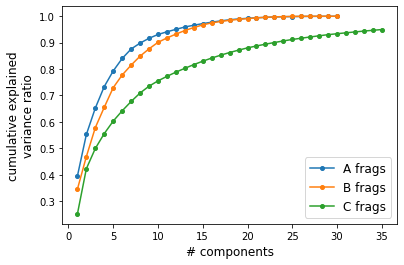

In [244]:
fig, ax = plt.subplots()

ax.plot(np.arange(cum_exp_var_a.shape[0])+1, cum_exp_var_a, marker='o', markersize=4, label='A frags')
ax.plot(np.arange(cum_exp_var_b.shape[0])+1, cum_exp_var_b, marker='o', markersize=4, label='B frags')
ax.plot(np.arange(cum_exp_var_c.shape[0])+1, cum_exp_var_c, marker='o', markersize=4, label='C frags')

ax.set_xlabel('# components', fontsize=12)
ax.set_ylabel('cumulative explained\nvariance ratio', fontsize=12)

ax.legend(loc='lower right', fontsize=12)

ax.set_facecolor('w')
plt.savefig('pca_exp_var_ratio.png', dpi=300)

In [220]:
# of components to choose
# A -->  30 --> ~1.0 EVR
# B --> 30 -->  ~1.0 EVR
# C --> 35 -->  0.9522642278929593 EVR

(array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
        28, 29]),)

In [247]:
df_red_a.shape, df_red_b.shape, df_red_c.shape

((32, 33), (60, 33), (223, 38))

In [55]:
df_red_a.to_csv('pca_desc_a.csv', index=False)
df_red_b.to_csv('pca_desc_b.csv', index=False)
df_red_c.to_csv('pca_desc_c.csv', index=False)
